# Read snow depth from camera photos

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [ ]:
main_path = r'/content/drive/MyDrive/Snow_data/Snow Camera Photos'

In [ ]:
site = 'AKB_FS8'
year = '2019'
month = '01'

In [ ]:
photo_dir = main_path + '/' + site + '/' + year + '/' + year + '-'+ month
photo_list = glob.glob(photo_dir + '/*')

/content/drive/MyDrive/Snow_data/Snow Camera Photos/AKB_FS8/2019/2019-01/WSCT2629.JPG


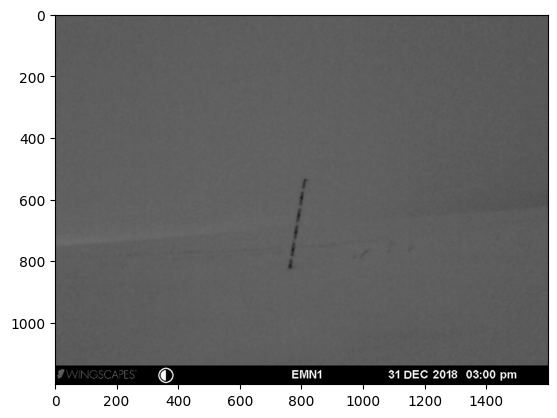

In [ ]:
print(photo_list[0])
img = cv2.imread(photo_list[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap = 'gray')

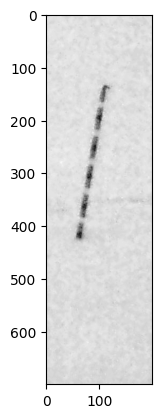

In [ ]:
# the relative location of the bar is in the range of:
cropped1 = img[400:1100, 700:900]
plt.imshow(cropped1, cmap = 'gray')

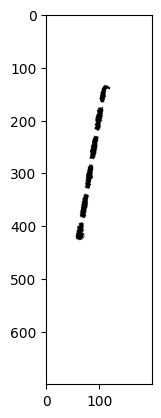

In [ ]:
# find out the location is by thresholding (so bar = 0 and background = 1)
thresh = cv2.threshold(cropped1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
plt.imshow(thresh, cmap = 'gray')

In [ ]:
# find the convex hull of the bar so that we can remove the background
from skimage.morphology import convex_hull_image
from skimage.util import invert

invert_thresh = invert(thresh)
c_hull = convex_hull_image(invert_thresh)

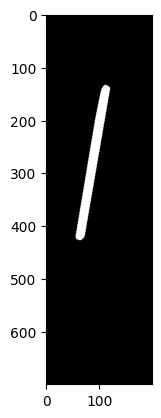

In [ ]:
plt.imshow(c_hull, cmap = 'gray')

105 0


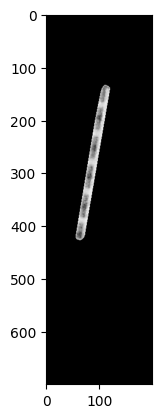

In [ ]:
# mask the background using the convex hull
masked = cropped1 * c_hull
plt.imshow(masked, cmap = 'gray')
print(np.max(masked), np.min(masked))

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0, 77, 74, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)
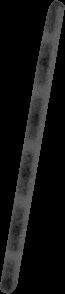

In [ ]:
# a function that crops to the content
def crop_to_nonzero(im):
  non_empty_columns = np.where(im.max(axis=0)>0)[0]
  non_empty_rows = np.where(im.max(axis=1)>0)[0]
  crop_box = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
  result = im[crop_box[0]:crop_box[1]+1, crop_box[2]:crop_box[3]+1]
  return result

cropped2 = crop_to_nonzero(masked)
cropped2

255 0


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 187, 179, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
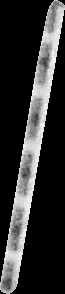

In [ ]:
# enhance the contrast by rescaling
rescaled = ((cropped2 - cropped2.min()) * (1/(cropped2.max() - cropped2.min()) * 255)).astype('uint8')
print(np.max(rescaled), np.min(rescaled))
rescaled

In [ ]:
# find out the angle of the bar
import math
x= rescaled.shape[0]
y= rescaled.shape[1]
angle = math.degrees(math.atan2(x,y))
angle

77.5331113368225

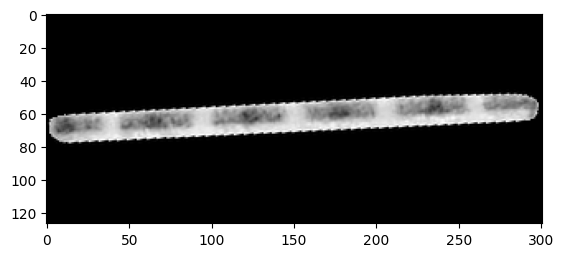

In [ ]:
from scipy import ndimage

#rotation angle in degree
rotated = ndimage.rotate(rescaled, -angle)
plt.imshow(rotated, cmap = 'gray')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
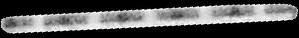

In [ ]:
# crop to content again
cropped3 = crop_to_nonzero(rotated)
cropped3

In [ ]:
# project aggregated values to the x axis
projection = np.sum(cropped3, axis=0)

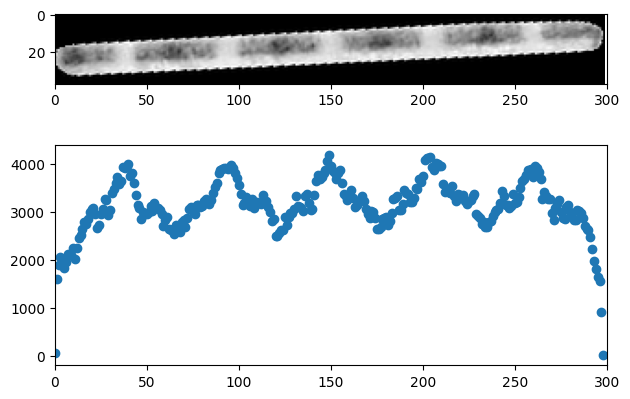

In [ ]:
# peaks correspond to whites and valleys to black
fig, axs = plt.subplots(2)
axs[0].imshow(cropped3, cmap="gray")
axs[1].scatter(range(len(projection)), projection)
axs[0].set_xlim([0, 300])
axs[1].set_xlim([0, 300])
fig.tight_layout()

In [ ]:
# gradient = np.gradient(projection)
# from scipy.signal import argrelextrema
# peaks = argrelextrema(projection, np.greater)
# distances = np.diff(peaks)

In [ ]:
# find peaks and hights
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
peaks, _ = find_peaks(projection)
peak_heights = projection[peaks]

In [ ]:
# cluster the white, grey and black using KMEANS
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0).fit(peak_heights.reshape(-1, 1))

In [ ]:
# clusters correspond to white, grey and black
high_peaks = peaks[kmeans.labels_ == 0]
mid_peaks = peaks[kmeans.labels_ == 1]
low_peaks = peaks[kmeans.labels_ == 2]

In [ ]:
# distances1 = np.diff(high_peaks)

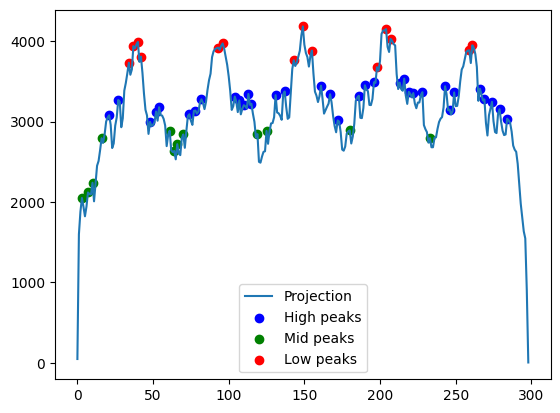

[1 1 1 1 0 0 2 2 2 2 0 0 0 1 1 1 1 0 0 0 2 2 0 0 0 0 0 1 1 0 0 2 2 2 0 0 0
 1 0 0 0 2 2 2 0 0 0 0 0 1 0 0 0 2 2 0 0 0 0 0]


In [ ]:
plt.figure()
plt.plot(projection, label='Projection')
plt.scatter(high_peaks, projection[high_peaks], color='blue', label='High peaks') # Draw high peaks
plt.scatter(mid_peaks, projection[mid_peaks], color='green', label='Mid peaks') # Draw mid peaks
plt.scatter(low_peaks, projection[low_peaks], color='red', label='Low peaks') # Draw low peaks
plt.legend()
plt.show()
print(kmeans.labels_)

In [ ]:
# group the same clusters so we see the cycles equally distanced
from itertools import groupby
print([k for k, g in groupby(kmeans.labels_)])
print('number of marks:', len([k for k, g in groupby(kmeans.labels_)]))

[1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0]
number of marks: 20


In [ ]:
# if each mark is 5cm, then the reading is

print (5 * len([k for k, g in groupby(kmeans.labels_)]), 'cm')

100 cm


# Step 2 : automation and batch processing